# Importar TensorFlow e Bibliotecas necessárias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import os

import cv2

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

# Funções Auxiliares


In [2]:
def show_preds_3(set1, set2, set3, count):
  columns = 6
  rows = int(count*3 / columns) + 1  
  plt.figure(figsize=(15, 2 * rows))
  for n in range(count):
      ax = plt.subplot(rows, columns, n*3+1)
      plt.title("original");
      plt.imshow(set1[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*3+2)
      plt.title("reconst");
      plt.imshow(set2[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*3+3)
      plt.title("noisy");
      plt.imshow(set3[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')

def show_preds(set1, set2, count):
  columns = 4
  rows = int(count*2 / columns) + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.title("reconst");
      plt.imshow(set1[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*2+2)
      plt.title("original");
      plt.imshow(set2[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')    
        
def plot_scatter(x,y,train_Y):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 'darkgreen', 'yellow', 'brown', 'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10,10))
    plt.scatter(x, y, c = train_Y, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()

# Carregar e preparar o dataset


In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Reescalar os inputs
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print ('Train shape: ', x_train.shape)
print ('Test shape: ', x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
Train shape:  (60000, 28, 28)
Test shape:  (10000, 28, 28)


# Configuração

In [4]:
HEIGHT = 32
WIDTH = 32
NUM_CHANNELS = 1
BATCH_SIZE = 32
LATENT_SPACE_DIM = 2

# Autoencoder de reconstrução

Arquitetura

In [5]:
inputs = Input(shape =(WIDTH, HEIGHT, NUM_CHANNELS))
    
# Arquitetura do Encoder    
x = Conv2D(32, (3, 3), strides=2, padding="same")(inputs)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

volumeSize = K.int_shape(x)
x = Flatten()(x)

# Espaço Latente
latent = Dense(LATENT_SPACE_DIM, name="latent")(x)

# Arquitetura do Decoder
latentInputs = Input(shape=(LATENT_SPACE_DIM,))
y = Dense(np.prod(volumeSize[1:]))(latentInputs)
y = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(y)

y = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization()(y) 

y = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization()(y)    

y = Conv2DTranspose(NUM_CHANNELS, (3, 3), padding="same")(y)
outputs = Activation("sigmoid", name="decoded")(y)

encoder = Model(inputs, latent, name="encoder")
decoder = Model(latentInputs, outputs, name="decoder")

autoencoder = Model(inputs=inputs, outputs=decoder(encoder(inputs)))
 
# Escrever sumários do encoder e decoder
encoder.summary() 
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256 

Preparar o modelo

In [6]:
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

Trainar o modelo

In [ ]:
EPOCHS = 25

# Treinar o autoencoder
history = autoencoder.fit(
	x_train, x_train,
	validation_data=(x_test, x_test),
	epochs=EPOCHS,
	batch_size=BATCH_SIZE)

Epoch 1/25
1875/1875 [==============================] - 146s 78ms/step - loss: 0.0300 - val_loss: 0.0303
Epoch 2/25
1875/1875 [==============================] - 147s 78ms/step - loss: 0.0299 - val_loss: 0.0295
Epoch 3/25
1875/1875 [==============================] - 147s 79ms/step - loss: 0.0297 - val_loss: 0.0295
Epoch 4/25
1875/1875 [==============================] - 147s 78ms/step - loss: 0.0297 - val_loss: 0.0296
Epoch 5/25
1875/1875 [==============================] - 148s 79ms/step - loss: 0.0296 - val_loss: 0.0292
Epoch 6/25
1875/1875 [==============================] - 150s 80ms/step - loss: 0.0295 - val_loss: 0.0301
Epoch 7/25
1875/1875 [==============================] - 150s 80ms/step - loss: 0.0294 - val_loss: 0.0291
Epoch 8/25
1875/1875 [==============================] - 148s 79ms/step - loss: 0.0294 - val_loss: 0.0292
Epoch 9/25
1875/1875 [==============================] - 147s 78ms/step - loss: 0.0293 - val_loss: 0.0294
Epoch 10/25
1875/1875 [==============================] 

Save e Load Modelos

In [ ]:
encoder.save('./encoderFashion{}.h5'.format(LATENT_SPACE_DIM))
decoder.save('./decoderFashion{}.h5'.format(LATENT_SPACE_DIM))

autoencoder.save('./autoencoderFashion{}.h5'.format(LATENT_SPACE_DIM))


In [7]:
ls_dim = 2

autoencoder = tf.keras.models.load_model('./autoencoderFashion{}.h5'.format(ls_dim))

Resultados

In [8]:
recon = autoencoder.predict(x_test)

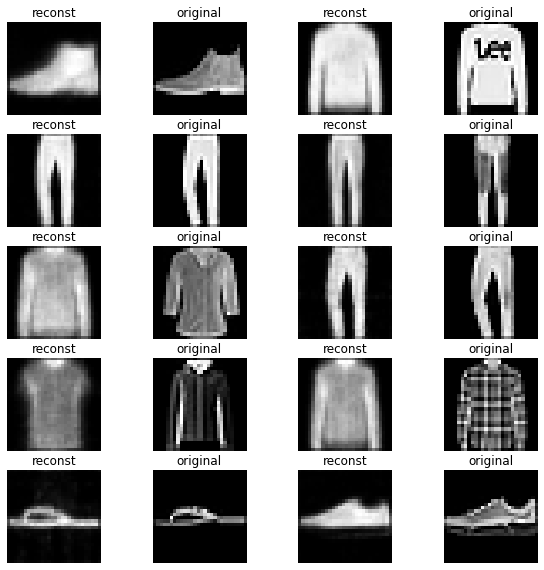

In [10]:
test_XImage = (x_test * 255).astype("uint8").squeeze() 
reconImage = (recon * 255).astype("uint8").squeeze()
show_preds(reconImage, test_XImage, 10)

# Autoencoder de Remoção de Ruído

Adição de ruído

In [11]:
noisyTrain = x_train.copy()
noisyTest = x_test.copy()

prob = 0.1

for i in range(len(noisyTrain)):
    probs = np.random.random(noisyTrain.shape[1:])
    noisyTrain[i][probs < (prob / 2)] = 0
    noisyTrain[i][probs > 1 - (prob / 2)] = 1
    
for i in range(len(noisyTest)):
    probs = np.random.random(noisyTrain.shape[1:])
    noisyTest[i][probs < (prob / 2)] = 0
    noisyTest[i][probs > 1 - (prob / 2)] = 1

Plot de imagem com ruído do train set

(-0.5, 27.5, 27.5, -0.5)

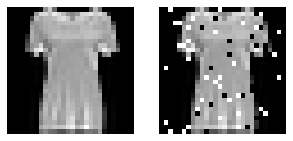

In [ ]:
fig = plt.figure(figsize=(5, 10))

ax = plt.subplot(1, 2, 1 )
plt.imshow(x_train[10], cmap=plt.get_cmap('gray'))
plt.axis('off')
ax = plt.subplot(1, 2, 2 )
plt.imshow(noisyTrain[10], cmap=plt.get_cmap('gray'))
plt.axis('off')

Criar e Treinar Autoencoder com o train set com ruído

In [12]:
autoencoderNoise = Model(inputs=inputs, outputs=decoder(encoder(inputs)))

opt = Adam(learning_rate=1e-3)
autoencoderNoise.compile(loss="mse", optimizer=opt)

In [ ]:
# Treinar o autoencoder
history = autoencoderNoise.fit(
	noisyTrain, x_train,
  validation_data=(noisyTest, x_test),
	epochs=EPOCHS,
	batch_size=BATCH_SIZE)

Epoch 1/25
1875/1875 [==============================] - 146s 77ms/step - loss: 0.0313 - val_loss: 0.0304
Epoch 2/25
1875/1875 [==============================] - 145s 77ms/step - loss: 0.0304 - val_loss: 0.0302
Epoch 3/25
1875/1875 [==============================] - 145s 77ms/step - loss: 0.0302 - val_loss: 0.0300
Epoch 4/25
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0301 - val_loss: 0.0300
Epoch 5/25
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 6/25
1875/1875 [==============================] - 145s 77ms/step - loss: 0.0299 - val_loss: 0.0298
Epoch 7/25
1875/1875 [==============================] - 143s 77ms/step - loss: 0.0298 - val_loss: 0.0295
Epoch 8/25
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0297 - val_loss: 0.0296
Epoch 9/25
1875/1875 [==============================] - 145s 77ms/step - loss: 0.0297 - val_loss: 0.0300
Epoch 10/25
1875/1875 [==============================] 

Save autoencoder

In [ ]:
autoencoderNoise.save('autoencoderFashion_denoise.h5')

Load autoencoder

In [13]:
autoencoderNoise = tf.keras.models.load_model('./autoencoderFashion_denoise.h5')

Resultados

(10000, 28, 28, 1)
(10000, 28, 28)


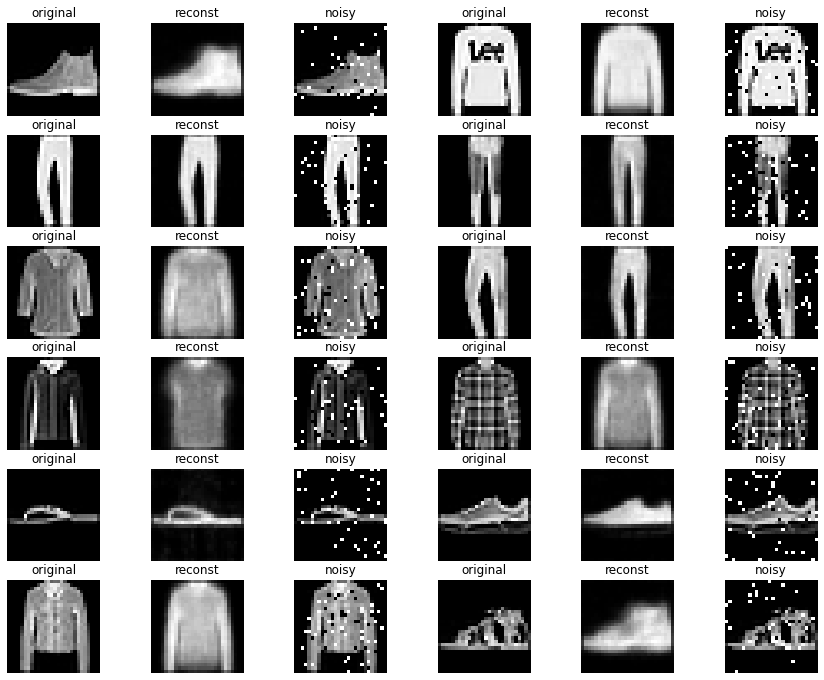

In [14]:
recon = autoencoderNoise.predict(noisyTest)
print(recon.shape)
print(x_test.shape)
show_preds_3((x_test* 255).astype("uint8").squeeze(), (recon* 255).astype("uint8").squeeze(), (noisyTest* 255).astype("uint8").squeeze(), 12)   